## Deploying MLflow Tracking Server on AWS with S3-Backed Artifact Storage (DONE)

In [2]:
# !pip install mlflow
# !pip install boto3
# !pip install awscli

# !aws configure   # I have configured the aws from terminal as this is was not worked in notebook'

    * Test MLFlow

In [4]:
# import mlflow

# mlflow.set_tracking_uri("http://ec2-43-205-177-148.ap-south-1.compute.amazonaws.com:5000/")   # URL of MLFlow UI

# with mlflow.start_run():
#     mlflow.log_param("param1", 25)
#     mlflow.log_metric("metric1", 2.89)

## Creation of baseline model

In [6]:
import mlflow
import mlflow.sklearn
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.ensemble                import RandomForestClassifier
from mlflow.models.signature         import infer_signature
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing           import StandardScaler
from sklearn.model_selection         import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics                 import *

In [7]:
df = pd.read_csv('preprocessed_corpus.csv')
df.head()

,raw_comment,category,word_count_raw,char_count_raw,num_unique_words,num_upper_words,num_punctuation_raw,cleaned_comment,num_stop_words,processed_comment,final_word_count,final_char_count
0,family mormon have never tried explain them t...,1,39,261,34,0,0,family mormon have never tried explain them th...,13,family mormon never tried explain still stare ...,26,171
1,buddhism has very much lot compatible with chr...,1,196,1269,136,0,0,buddhism has very much lot compatible with chr...,56,buddhism much lot compatible christianity espe...,140,842
2,seriously don say thing first all they won get...,-1,86,460,67,0,0,seriously don say thing first all they won get...,40,seriously say thing first get complex explain ...,46,230
3,what you have learned yours and only yours wha...,0,29,168,24,0,0,what you have learned yours and only yours wha...,14,learned want teach different focus goal not wr...,15,87
4,for your own benefit you may want read living ...,1,112,691,82,0,0,for your own benefit you may want read living ...,46,benefit may want read living buddha living chr...,66,397


In [8]:
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=10000)  # Bag of Words model with a limit of 1000 features

In [9]:
X          = vectorizer.fit_transform(df['processed_comment']).toarray()
y          = df['category']          

In [10]:
X, X.shape, y.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 (36640, 10000),
 (36640,))

In [11]:
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-13-201-96-130.ap-south-1.compute.amazonaws.com:5000/")

In [12]:
# # create an experiment 
# mlflow.create_experiment(
#                             name              = "Experiment_1_RF_Baseline",
#                             artifact_location = "s3://mlflow-s3-25/Experiment_1_RF_Baseline"
#                         )

In [13]:
# set an experiment
mlflow.set_experiment("Experiment_1_RF_Baseline")

<Experiment: artifact_location='s3://mlflow-s3-25/Experiment_1_RF_Baseline', creation_time=1756892534721, experiment_id='267284533830559238', last_update_time=1756892534721, lifecycle_stage='active', name='Experiment_1_RF_Baseline', tags={}>

Evaluation Metrics : (values close to 1 represent the GOOD Model)

	Accuracy     : 0.63    --> [TP + TN]/ALL       : The proportion of correctly predicted observations over total predictions
	Log Loss     : 0.95    --> Measures the performance of a classification model, Less is Good
	Macro  		       --> Macro average       : Treats all classes equally by computing the unweighted mean of per-class metrics
	  Precision  : 0.74    --> [TP]     /[TP + FP] : The proportion of true positive predictions over total positive predictions 
	  Recall     : 0.54    --> [TP]     /[TP + FN] : The proportion of true positive predictions over total actual positives.
	  F1-Score   : 0.48    --> The harmonic mean of precision and recall, useful when FP and FN both have serious consequences
	  ROC-AUC    : 0.84    --> Measures the ability of the model to distinguish between classes.
	Weighted  	       --> Weighted average    : Accounts for class imbalance by weighting each class metric by its support
	  P

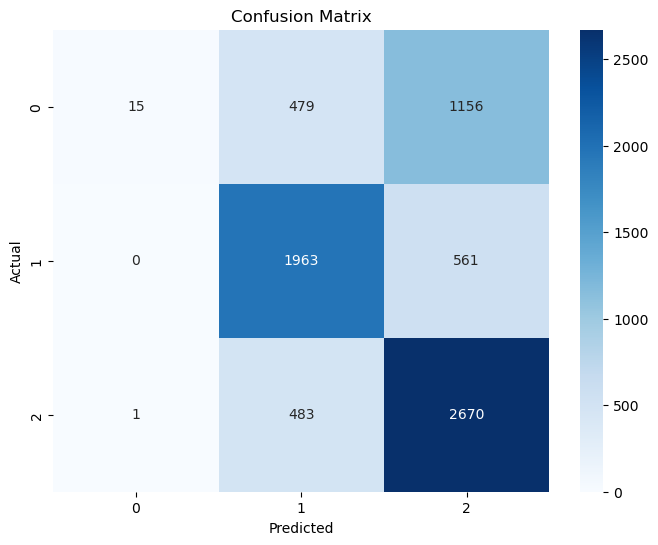

In [14]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName",  "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type",      "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description",     "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators   = 200
    max_depth      = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth",    max_depth)

    # Initialize and train the model
    model          = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred         = model.predict(X_test)

    
    # Step 1: Compute Evaluation Metrics
    accuracy           = accuracy_score       (y_test, y_pred)
    
    macro_precision    = precision_score      (y_test, y_pred, average='macro')
    macro_recall       = recall_score         (y_test, y_pred, average='macro')         # Recall or Sensitivity
    macro_F1_score     = f1_score             (y_test, y_pred, average='macro')
    macro_roc_auc      = roc_auc_score        (y_test, model.predict_proba(X_test), average='macro', multi_class='ovr')
    weighted_precision = precision_score      (y_test, y_pred, average='weighted')
    weighted_recall    = recall_score         (y_test, y_pred, average='weighted')         # Recall or Sensitivity
    weighted_F1_score  = f1_score             (y_test, y_pred, average='weighted')
    weighted_roc_auc   = roc_auc_score        (y_test, model.predict_proba(X_test), average='weighted', multi_class='ovr')
    
    log_loss_value     = log_loss             (y_test, model.predict_proba(X_test))
    cm                 = confusion_matrix     (y_test,y_pred)
    cr                 = classification_report(y_test, y_pred)
    
    # Step 7: Log Class-wise Metrics from Classification Report
    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        clean_label = label.replace(" avg", "")  # Remove " avg" from label if present
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                mlflow.log_metric(f"{clean_label}_{metric}", value)
        else:
            mlflow.log_metric(f"{clean_label}", metrics)

    # Step 6: Log Remaining Metrics to MLflow
    mlflow.log_metric("log_loss",         log_loss_value)        
    mlflow.log_metric("macro_roc_auc",    macro_roc_auc)
    mlflow.log_metric("weighted_roc_auc", weighted_roc_auc)
    
    # Step 8: Plot and Log Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Step 9: saving and logging the dataset
    df.to_csv("dataset.csv", index=False)
    mlflow.log_artifact("dataset.csv")
    
    # Step 10: Log Model and Dataset
    input_example = X_test[:5]                                       # input_example provides a sample input for the model, 
                                                                     # useful for UI display and validation
    signature     = infer_signature(X_train, model.predict(X_train)) # signature defines the expected input/output schema of the model, 
                                                                     # enabling reproducibility and serving
    
    mlflow.sklearn.log_model(
                                sk_model      = model,
                                name          = "RF_model_baseline",
                                input_example = input_example,
                                signature     = signature
                            ) 
    # Step 11: Print Evaluation Summary
    print(f"\033[1m\033[4mEvaluation Metrics\033[0m : (values close to 1 represent the GOOD Model)\n")
    print(f'\tAccuracy     : {accuracy:.2f}    --> [TP + TN]/ALL       : The proportion of correctly predicted observations over total predictions')
    print(f'\tLog Loss     : {log_loss_value:.2f}    --> Measures the performance of a classification model, Less is Good')
    print(f'\t\033[1m\033[4mMacro\033[0m  \t\t       --> Macro average       : Treats all classes equally by computing the unweighted mean of per-class metrics')
    print(f'\t  Precision  : {macro_precision:.2f}    --> [TP]     /[TP + FP] : The proportion of true positive predictions over total positive predictions ')
    print(f'\t  Recall     : {macro_recall:.2f}    --> [TP]     /[TP + FN] : The proportion of true positive predictions over total actual positives.')
    print(f'\t  F1-Score   : {macro_F1_score:.2f}    --> The harmonic mean of precision and recall, useful when FP and FN both have serious consequences')
    print(f'\t  ROC-AUC    : {macro_roc_auc:.2f}    --> Measures the ability of the model to distinguish between classes.')
    
    print(f'\t\033[1m\033[4mWeighted\033[0m  \t       --> Weighted average    : Accounts for class imbalance by weighting each class metric by its support')
    print(f'\t  Precision  : {weighted_precision:.2f}    --> [TP]     /[TP + FP] : The proportion of true positive predictions over total positive predictions ')
    print(f'\t  Recall     : {weighted_recall:.2f}    --> [TP]     /[TP + FN] : The proportion of true positive predictions over total actual positives.')
    print(f'\t  F1-Score   : {weighted_F1_score:.2f}    --> The harmonic mean of precision and recall, useful when FP and FN both have serious consequences')
    print(f'\t  ROC-AUC    : {weighted_roc_auc:.2f}    --> Measures the ability of the model to distinguish between classes.')
    
    
    print(f'\nConfusion Matix      :         -->    \033[1m\033[4mORIGINAL\033[0m     \t\t\033[1m\033[4mSTANDARD\033[0m\n')
    def format_row(row):
        formatted = ' '.join(f"{val:>2}" for val in row)
        return f"[{formatted}]"
    
    for row1, row2 in zip(cm, np.flip(cm)):
        print("\t\t\t\t  ", format_row(row1), "\t       ", format_row(row2))
    
    print("\nClassification Rpt   :")
    print('\n'.join('\t\t\t\t' + line for line in cr.splitlines()))